env: KERAS_BACKEND=tensorflow


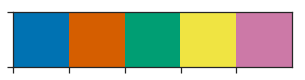

In [46]:
import sys
import os
from glob import glob
import random

import numy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import h5py
import pysam
from joblib import Parallel, delayed

%env KERAS_BACKEND tensorflow
import tensorflow as tf
from keras import (
    models, layers, activations,
    optimizers, losses, callbacks
)
import keras.backend as K

from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle


from adapter_detector.utils import (
    get_fast5_read_id_mapping
)
from adapter_detector.signal import (
    get_fast5_fiveprime
)
from adapter_detector.model import load_model

import pybedtools
from pybedtools import featurefuncs

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [187]:
def get_fiveprime_for_reads_in_bam(bam_fn, read_id_filemap, size=3000, internal=False):
    with pysam.AlignmentFile(bam_fn) as bam:
        signals = Parallel(n_jobs=28)(
            delayed(get_fast5_fiveprime)(
                r.query_name, read_id_filemap[r.query_name], size, internal)
            for r in bam.fetch() if r.query_name in read_id_filemap
        )
    if internal:
        read_ids, sig_lens, fiveprime_signals, internal_signals = zip(*signals)
        return read_ids, np.asarray(fiveprime_signals), np.asarray(internal_signals)
    else:
        read_ids, sig_lens, fiveprime_signals = zip(*signals)
        return read_ids, np.asarray(fiveprime_signals)

In [168]:
adapter_test_set_bam_fn = '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/aligned_data/TAIR10/201902_col0_2918_5adapter.bam'
adapter_test_set_read_id_filemap = get_fast5_read_id_mapping(
    '/cluster/ggs_lab/mtparker/analysis_notebooks/fiveprime_adapter_identification/data/201805_col0_run16_5adapt_2918/summaries/',
    '/cluster/ggs_lab/mtparker/analysis_notebooks/fiveprime_adapter_identification/data/201805_col0_run16_5adapt_2918/fast5s/'
)
read_ids, adapter_test_set_signals = get_fiveprime_for_reads_in_bam(
    adapter_test_set_bam_fn, adapter_test_set_read_id_filemap, size=3000, internal=False)

/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/cluster/ggs_lab/mtparker/.conda/envs/ad

In [169]:
model = load_model('data/model_weights_070319.h5')

adapter_test_pred = model.predict(adapter_test_set_signals.reshape(-1, 3000, 1))

In [170]:
model_method_preds = pd.Series(adapter_test_pred.squeeze(), index=read_ids)

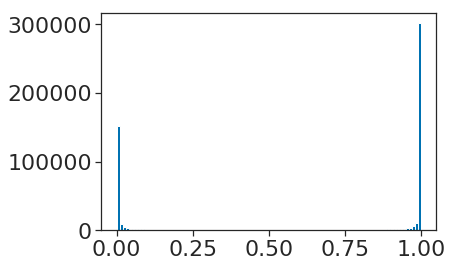

In [171]:
plt.hist(adapter_test_pred, bins=np.linspace(0, 1, 101))
plt.show()

In [172]:
blast_method_stringent_pass = '/cluster/gjb_lab/nschurch/git/NS_Nanopore_paper/manuscript/supplementary/fulllength_data/201902_col0_2918_5adapter_fulllength.bam'
blast_method_stringent_fail = '/cluster/gjb_lab/nschurch/git/NS_Nanopore_paper/manuscript/supplementary/fulllength_data/201902_col0_2918_5adapter_short.bam'
blast_method_relaxed_pass = '/cluster/gjb_lab/nschurch/git/NS_Nanopore_paper/manuscript/supplementary/fulllength_data/201902_col0_2918_5adapter_fulllength_relaxed.bam'
blast_method_relaxed_fail = '/cluster/gjb_lab/nschurch/git/NS_Nanopore_paper/manuscript/supplementary/fulllength_data/201902_col0_2918_5adapter_short_relaxed.bam'

In [173]:
def get_bam_read_ids(bam_fn):
    read_ids = []
    with pysam.AlignmentFile(bam_fn) as bam:
        for aln in bam.fetch():
            read_ids.append(aln.query_name)
    return read_ids


def get_pass_fail(pass_fn, fail_fn):
    pass_read_ids = get_bam_read_ids(pass_fn)
    fail_read_ids = get_bam_read_ids(fail_fn)
    pass_fail = pd.Series(
        [True] * len(pass_read_ids) + [False] * len(fail_read_ids),
        index = pass_read_ids + fail_read_ids
    )
    return pass_fail


blast_method_stringent = get_pass_fail(blast_method_stringent_pass, blast_method_stringent_fail)
blast_method_stringent.name = 'blast_stringent'
blast_method_relaxed = get_pass_fail(blast_method_relaxed_pass, blast_method_relaxed_fail)
blast_method_relaxed.name = 'blast_relaxed'
blast_method_stringent.head()

d30a5b1f-88ee-408a-95cb-1c32b3c516cc    True
b4ce3cbb-6604-47b4-9731-270f9e5a78e5    True
27050e19-732b-4210-bbc7-28fe0f16a3f3    True
2f71e5e3-6623-48e9-8b97-3f9d29278a59    True
2d5f070a-0f98-472c-8501-f6a689185cb3    True
Name: blast_stringent, dtype: bool

In [174]:
all_method_results = pd.concat(
    [blast_method_stringent[~blast_method_stringent.index.duplicated(keep='first')],
     blast_method_relaxed[~blast_method_relaxed.index.duplicated(keep='first')],
     model_method_preds[~model_method_preds.index.duplicated(keep='first')]],
    sort=True, axis=1,
    keys=['blast_stringent', 'blast_relaxed', 'model_pred']
)
all_method_results['model_thresh0.5'] = all_method_results['model_pred'] > 0.5
all_method_results['model_thresh0.9'] = all_method_results['model_pred'] > 0.9
all_method_results.head()

,blast_stringent,blast_relaxed,model_pred,model_thresh0.5,model_thresh0.9
000009fe-1028-4ca6-bb39-ca04bd46e065,False,True,0.877168,True,False
00002439-b051-473f-834c-3168fe831ce0,False,True,1.000000,True,True
00006129-54be-42b2-a066-6c6c24416715,True,True,0.998529,True,True
000071f0-57b9-4afb-be2f-667eea029946,False,False,0.899717,True,False
00008e71-06c8-436d-84c8-05ff4ff25da4,False,True,0.998531,True,True


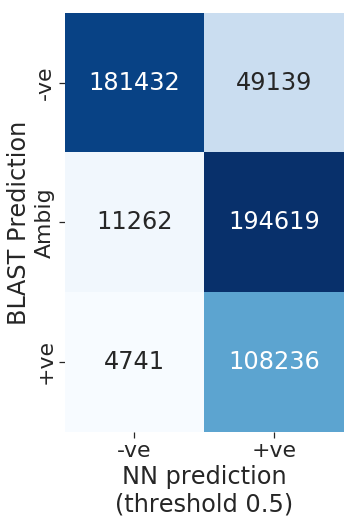

In [259]:
fig, ax = plt.subplots(figsize=(5, 8))

ax = sns.heatmap(
    pd.crosstab(
        columns=all_method_results['model_thresh0.5'],
        index=all_method_results.blast_stringent.astype('i') + \
                  all_method_results.blast_relaxed.astype('i')
    ),
    annot=True, cmap='Blues',
    fmt='d', square=True,
    cbar=False,
    xticklabels=['-ve', '+ve'],
    yticklabels=['-ve', 'Ambig', '+ve']
)
plt.setp(ax.get_yticklabels(), va='center')
ax.set_ylabel('BLAST Prediction')
ax.set_xlabel('NN prediction\n(threshold 0.5)')
plt.savefig('figures/comparison_to_blast_approach.svg')
plt.show()

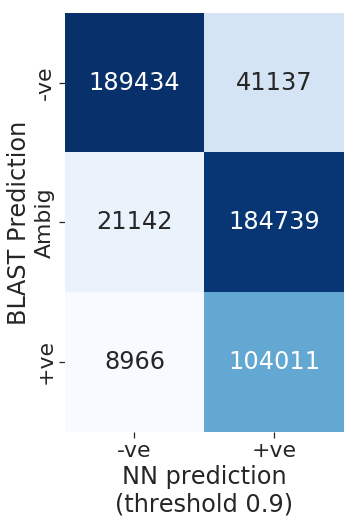

In [176]:
fig, ax = plt.subplots(figsize=(5, 8))

ax = sns.heatmap(
    pd.crosstab(
        columns=all_method_results['model_thresh0.9'],
        index=all_method_results.blast_stringent.astype('i') + \
                  all_method_results.blast_relaxed.astype('i')
    ),
    annot=True, cmap='Blues',
    fmt='d', square=True,
    cbar=False,
    xticklabels=['-ve', '+ve'],
    yticklabels=['-ve', 'Ambig', '+ve']
)
plt.setp(ax.get_yticklabels(), va='center')
ax.set_ylabel('BLAST Prediction')
ax.set_xlabel('NN prediction\n(threshold 0.9)')
plt.show()

In [188]:
no_adapter_test_set_bam_fn = '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918.bam'
no_adapter_test_set_read_id_filemap = get_fast5_read_id_mapping(
    '/cluster/ggs_lab/mtparker/analysis_notebooks/fiveprime_adapter_identification/data/201805_col0_run13_no_adapter_2918/summaries',
    '/cluster/ggs_lab/mtparker/analysis_notebooks/fiveprime_adapter_identification/data/201805_col0_run13_no_adapter_2918/fast5s'
)
read_ids, no_adapter_test_set_signals = get_fiveprime_for_reads_in_bam(
    no_adapter_test_set_bam_fn, no_adapter_test_set_read_id_filemap, size=3000, internal=False
)

In [189]:
no_adapter_test_pred = model.predict(
    no_adapter_test_set_signals.reshape(-1, 3000, 1))
no_adapter_model_method_preds = pd.Series(no_adapter_test_pred.squeeze(), index=read_ids)

In [190]:
adapter_model_method_preds = model_method_preds.copy()
adapter_model_method_preds = adapter_model_method_preds.to_frame()
adapter_model_method_preds['5\' Adapter'] = True
no_adapter_model_method_preds = no_adapter_model_method_preds.to_frame()
no_adapter_model_method_preds['5\' Adapter'] = False

nn_predictions = pd.concat([
    adapter_model_method_preds,
    no_adapter_model_method_preds,
])
nn_predictions.columns = ['Prediction', 'Adapter Ligation']
nn_predictions['thresh0.5'] = nn_predictions.Prediction > 0.5
nn_predictions['thresh0.9'] = nn_predictions.Prediction > 0.9
nn_predictions['thresh0.99'] = nn_predictions.Prediction > 0.99

nn_predictions.head()

,Prediction,Adapter Ligation,thresh0.5,thresh0.9,thresh0.99
6246ba6d-90db-42ba-aaa8-ba5f22bef75a,0.016451,True,False,False,False
d30a5b1f-88ee-408a-95cb-1c32b3c516cc,1.000000,True,True,True,True
188623a3-e4ea-4007-a603-9fdafe3daa5b,0.477889,True,False,False,False
b4ce3cbb-6604-47b4-9731-270f9e5a78e5,1.000000,True,True,True,True
27050e19-732b-4210-bbc7-28fe0f16a3f3,1.000000,True,True,True,True


63.92681051493953
1.2446088306198606
37.85597537677776


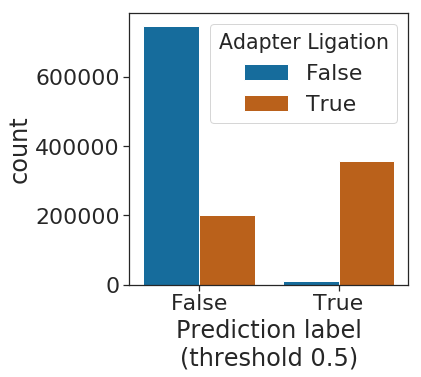

In [260]:
print(sum(nn_predictions[nn_predictions['Adapter Ligation']]['thresh0.5']) / len(nn_predictions[nn_predictions['Adapter Ligation']]) * 100)
print(sum(nn_predictions[~nn_predictions['Adapter Ligation']]['thresh0.5']) / len(nn_predictions[~nn_predictions['Adapter Ligation']]) * 100)
print(sum(nn_predictions[nn_predictions['Adapter Ligation']]['thresh0.5']) / sum(nn_predictions[~nn_predictions['Adapter Ligation']]['thresh0.5']))

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='thresh0.5', hue='Adapter Ligation', data=nn_predictions, ax=ax)
ax.set_xlabel('Prediction label\n(threshold 0.5)')
plt.savefig('figures/prediction_countplot.svg')
plt.show()

59.900636079641686
0.356527195270962
123.82919599851797


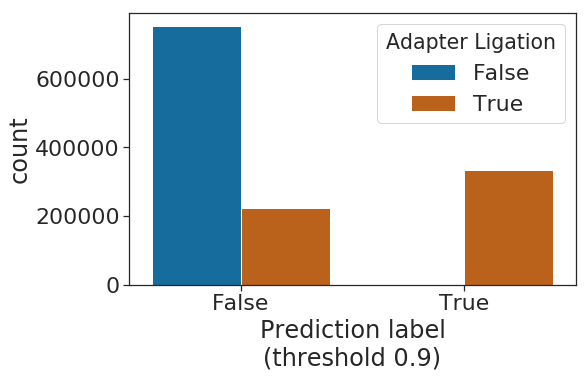

In [192]:
print(sum(nn_predictions[nn_predictions['Adapter Ligation']]['thresh0.9']) / len(nn_predictions[nn_predictions['Adapter Ligation']]) * 100)
print(sum(nn_predictions[~nn_predictions['Adapter Ligation']]['thresh0.9']) / len(nn_predictions[~nn_predictions['Adapter Ligation']]) * 100)
print(sum(nn_predictions[nn_predictions['Adapter Ligation']]['thresh0.9']) / sum(nn_predictions[~nn_predictions['Adapter Ligation']]['thresh0.9']))


fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='thresh0.9', hue='Adapter Ligation', data=nn_predictions, ax=ax)
ax.set_xlabel('Prediction label\n(threshold 0.9)')
plt.show()

54.0501013533495
0.09154255143489318
435.16883116883116


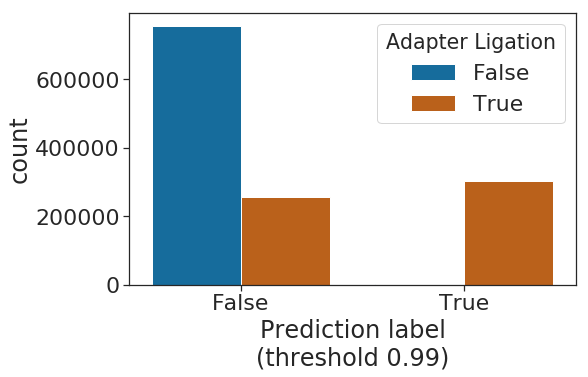

In [193]:
print(sum(nn_predictions[nn_predictions['Adapter Ligation']]['thresh0.99']) / len(nn_predictions[nn_predictions['Adapter Ligation']]) * 100)
print(sum(nn_predictions[~nn_predictions['Adapter Ligation']]['thresh0.99']) / len(nn_predictions[~nn_predictions['Adapter Ligation']]) * 100)
print(sum(nn_predictions[nn_predictions['Adapter Ligation']]['thresh0.99']) / sum(nn_predictions[~nn_predictions['Adapter Ligation']]['thresh0.99']))


fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='thresh0.99', hue='Adapter Ligation', data=nn_predictions, ax=ax)
ax.set_xlabel('Prediction label\n(threshold 0.99)')
plt.show()

In [3]:
from threeprime_bias import get_coverage

In [3]:
no_adapter_filtered_bam_fn = '/cluster/ggs_lab/mtparker/adapter_DRS_pipeline/201901_col0_2918/aligned_data/201901_col0_adapter_2918.fails.bam'
adapter_filtered_bam_fn = '/cluster/ggs_lab/mtparker/adapter_DRS_pipeline/201901_col0_2918/aligned_data/201901_col0_adapter_2918.passes.bam'
gtf_fn = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.no_chr.gtf'

In [5]:
no_adapter_cov = get_coverage(gtf_fn, no_adapter_filtered_bam_fn)
adapter_cov = get_coverage(gtf_fn, adapter_filtered_bam_fn)

In [6]:
def three_prime_bias_metric(arr):
    arr = np.trim_zeros(arr)
    med = np.median(arr)
    iqr = stats.iqr(arr)
    return iqr / med

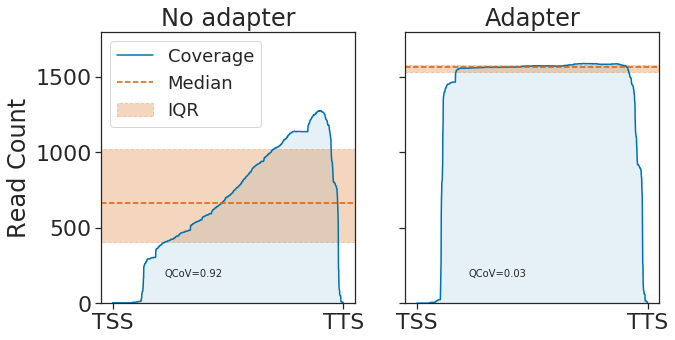

In [7]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)

for ax, cov, title in zip(axes, [no_adapter_cov, adapter_cov], ['No adapter', 'Adapter']):
    c = np.trim_zeros(cov['AT2G39730'][::-1])
    ax.plot(c, label='Coverage')
    ax.fill_between(np.arange(len(c)), np.repeat(0, len(c)), c, color=pal[0], alpha=0.1)
    ax.set_xticks([0, len(c)])
    ax.set_xticklabels(['TSS', 'TTS'])
    ax.axhline(np.median(c), ls='--', color=pal[1], label='Median')
    ax.axhspan(np.percentile(c, 25),
               np.percentile(c, 75),
               ls='--', color=pal[1],
               alpha=0.25, label='IQR')
    ax.set_title(title)
    ax.set_ylim(0, 1800)
    ax.annotate(s=f'QCoV={three_prime_bias_metric(c):.2f}', xy=(0.25, 0.1), xycoords='axes fraction')
axes[0].set_ylabel('Read Count')
axes[0].legend(loc=2, fontsize=18)
plt.savefig('figures/rca_three_prime_bias.svg')
plt.show()

0.02448210922787194
0.45
[0.43019262 0.4679157 ]
0.5490074441687345
0.07894736842105263
[0.07142857 0.08867752]


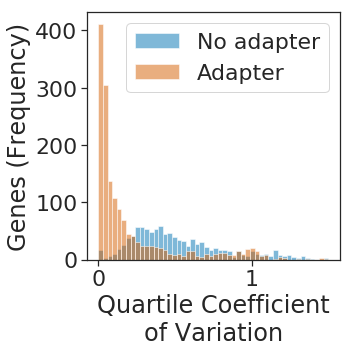

In [9]:
def bootstrap(arr, nboots=1000, func=np.median):
    boot_res = []
    for _ in range(nboots):
        samp = np.random.choice(arr, size=len(arr), replace=True)
        boot_res.append(func(samp))
    return np.array(boot_res)


MIN_COVERAGE = 25

fig, ax = plt.subplots(figsize=(5, 5))
for cov, label in zip([no_adapter_cov, adapter_cov], ['No adapter', 'Adapter']):
    qcov = np.array([three_prime_bias_metric(arr)
                     for arr in cov.values()
                     if arr.max() >= MIN_COVERAGE])
    print(sum(qcov < 0.1) / len(qcov))
    print(np.median(qcov))
    boot_meds = bootstrap(qcov)
    print(np.percentile(boot_meds, (2.5, 97.5)))
    ax.hist(qcov, label=label, bins=np.linspace(0, 1.5, 51), alpha=0.5)
plt.legend()
ax.set_xlabel('Quartile Coefficient\nof Variation')
ax.set_ylabel('Genes (Frequency)')
plt.tight_layout()
plt.savefig('figures/global_three_prime_bias.svg')
plt.show()

In [4]:
non_full_length = pybedtools.BedTool(no_adapter_filtered_bam_fn).bam_to_bed()
non_full_length_tss = non_full_length.each(
    featurefuncs.five_prime, upstream=0, downstream=0
).saveas()
full_length = pybedtools.BedTool(adapter_filtered_bam_fn).bam_to_bed()
full_length_tss = full_length.each(
    featurefuncs.five_prime, upstream=0, downstream=0
).saveas()
riken_tss = pybedtools.BedTool('/cluster/ggs_lab/mtparker/Arabidopsis_annotations/riken_rarge/riken_tss.bed')
nanoPARE_tss = pybedtools.BedTool('/cluster/ggs_lab/mtparker/nanoPARE/peaks/final/nanoPARE_peaks.bed')

In [5]:
non_full_length_dist_bt = non_full_length_tss.sort().closest(
    riken_tss, D="a", t="first", s=True)
full_length_dist_bt = full_length_tss.sort().closest(
    riken_tss, D="a", t="first", s=True)

In [6]:
non_full_length_dist = non_full_length_dist_bt.to_dataframe(
    header=None).set_index(3).iloc[:, -1]
full_length_dist = full_length_dist_bt.to_dataframe(
    header=None).set_index(3).iloc[:, -1]

/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/pybedtools/bedtool.py:3433: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3

In [7]:
non_full_length_nanoPARE_dist_bt = non_full_length_tss.sort().closest(
    nanoPARE_tss, D="a", t="first", s=True
)
full_length_nanoPARE_dist_bt = full_length_tss.sort().closest(
    nanoPARE_tss, D="a", t="first", s=True
)

In [8]:
non_full_length_nanoPARE_dist = non_full_length_nanoPARE_dist_bt.to_dataframe(
    header=None).set_index(3).iloc[:, -1]
full_length_nanoPARE_dist = full_length_nanoPARE_dist_bt.to_dataframe(
    header=None).set_index(3).iloc[:, -1]

/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/pybedtools/bedtool.py:3433: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 19 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3

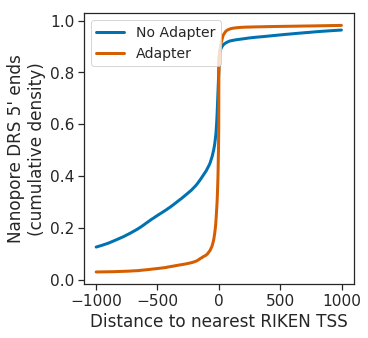

In [41]:
fig, ax = plt.subplots(figsize=(5.4, 5))

bins = np.concatenate(
    [[-np.inf], np.arange(-1000, 1001), [np.inf]]
)
non_full_length_hist = np.cumsum(
    np.histogram(non_full_length_dist, bins=bins)[0],
)
non_full_length_hist =  non_full_length_hist / non_full_length_hist[-1]

full_length_hist = np.cumsum(
    np.histogram(full_length_dist, bins=bins)[0],
)
full_length_hist =  full_length_hist / full_length_hist[-1]


ax.plot(
    np.arange(-1000, 1000),
    non_full_length_hist[1:-1],
    label='No Adapter',
    linewidth=3
)

ax.plot(
    np.arange(-1000, 1000),
    full_length_hist[1:-1],
    label='Adapter',
    linewidth=3
)
plt.legend(fontsize=14, loc=2)
ax.set_xlabel('Distance to nearest RIKEN TSS')
ax.set_ylabel('Nanopore DRS 5\' ends\n(cumulative density)')
plt.tight_layout()
plt.savefig('figures/distance_to_est_tss_riken.svg')
plt.show()

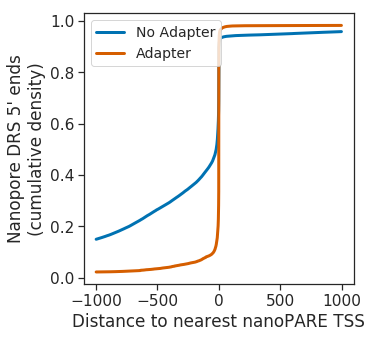

In [43]:
fig, ax = plt.subplots(figsize=(5.4, 5))

bins = np.concatenate(
    [[-np.inf], np.arange(-1000, 1001), [np.inf]]
)
nanoPARE_non_full_length_hist = np.cumsum(
    np.histogram(non_full_length_nanoPARE_dist, bins=bins)[0],
)
nanoPARE_non_full_length_hist =  nanoPARE_non_full_length_hist / nanoPARE_non_full_length_hist[-1]

nanoPARE_full_length_hist = np.cumsum(
    np.histogram(full_length_nanoPARE_dist, bins=bins)[0],
)
nanoPARE_full_length_hist =  nanoPARE_full_length_hist / nanoPARE_full_length_hist[-1]


ax.plot(
    np.arange(-1000, 1000),
    nanoPARE_non_full_length_hist[1:-1],
    label='No Adapter',
    linewidth=3
)

ax.plot(
    np.arange(-1000, 1000),
    nanoPARE_full_length_hist[1:-1],
    label='Adapter',
    linewidth=3
)
plt.legend(fontsize=14, loc=2)
ax.set_xlabel('Distance to nearest nanoPARE TSS')
ax.set_ylabel('Nanopore DRS 5\' ends\n(cumulative density)')
plt.tight_layout()
plt.savefig('figures/distance_to_est_tss_nanoPARE.svg')
plt.show()

In [15]:
sum(np.abs(full_length_dist) <= 5) / len(full_length_dist)

0.4461623926790567

In [16]:
sum(np.abs(full_length_dist) <= 13) / len(full_length_dist)

0.5964898858015348

In [17]:
sum(np.abs(full_length_nanoPARE_dist) <= 5) / len(full_length_nanoPARE_dist)

0.7518902789928713

In [18]:
sum(np.abs(full_length_nanoPARE_dist) <= 13) / len(full_length_nanoPARE_dist)

0.815000482341318

In [27]:
def tss(record):
    if record[6] == '+':
        record[3] = int(record[3])
        record[4] = int(record[3]) + 1
    elif record[6] == '-':
        record[3] = int(record[4]) - 1
        record[4] = int(record[4])
    else:
        raise ValueError()
    return record

araport11 = pybedtools.BedTool(
    '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.no_chr.gff'
)
araport11_transcripts = araport11.filter(lambda record: record[2] == 'mRNA').saveas()
araport11_tss = araport11_transcripts.each(tss).saveas()
araport11_tss.head()

1	Araport11	mRNA	3632	3633	.	+	.	ID=AT1G01010.1;Parent=AT1G01010;Name=AT1G01010.1;Note=NAC domain containing protein 1;conf_class=2;symbol=NAC001;Alias=ANAC001,NAC domain containing protein 1;full_name=NAC domain containing protein 1;computational_description=NAC domain containing protein 1 (NAC001)%3B FUNCTIONS IN: sequence-specific DNA binding transcription factor activity%3B INVOLVED IN: multicellular organismal development%2C regulation of transcription%3B LOCATED IN: cellular_component unknown%3B EXPRESSED IN: 7 plant structures%3B EXPRESSED DURING: 4 anthesis%2C C globular stage%2C petal differentiation and expansion stage%3B CONTAINS InterPro DOMAIN/s: No apical meristem (NAM) protein (InterPro:IPR003441)%3B BEST Arabidopsis thaliana protein match is: NAC domain containing protein 69 (TAIR:AT4G01550.1)%3B Has 2503 Blast hits to 2496 proteins in 69 species: Archae - 0%3B Bacteria - 0%3B Metazoa - 0%3B Fungi - 0%3B Plants - 2502%3B Viruses - 0%3B Other Eukaryotes - 1 (source: NCBI

In [28]:
araport11_non_full_length_dist = non_full_length_tss.sort().closest(
    araport11_tss.sort(), D="a", t="first", s=True)
araport11_full_length_dist = full_length_tss.sort().closest(
    araport11_tss.sort(), D="a", t="first", s=True)

In [29]:
araport11_non_full_length_dist = araport11_non_full_length_dist.to_dataframe(
    header=None).iloc[:, -1].values
araport11_full_length_dist = araport11_full_length_dist.to_dataframe(
    header=None).iloc[:, -1].values 

/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/pybedtools/bedtool.py:3433: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 16 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/cluster/ggs_lab/mtparker/.conda/envs/adapter_pipeline/lib/python3

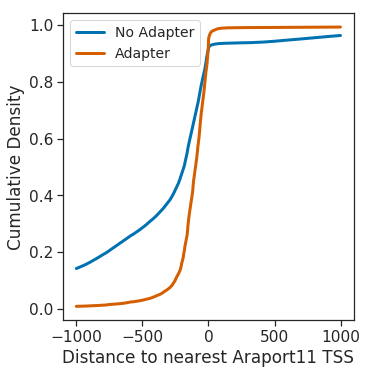

In [44]:
fig, ax = plt.subplots(figsize=(5.4, 5.5))

bins = np.concatenate(
    [[-np.inf], np.arange(-1000, 1001), [np.inf]]
)
araport11_non_full_length_hist = np.cumsum(
    np.histogram(araport11_non_full_length_dist, bins=bins)[0],
)
araport11_non_full_length_hist =  araport11_non_full_length_hist / araport11_non_full_length_hist[-1]

araport11_full_length_hist = np.cumsum(
    np.histogram(araport11_full_length_dist, bins=bins)[0],
)
araport11_full_length_hist =  araport11_full_length_hist / araport11_full_length_hist[-1]


ax.plot(
    np.arange(-1000, 1000),
    araport11_non_full_length_hist[1:-1],
    label='No Adapter',
    linewidth=3
)

ax.plot(
    np.arange(-1000, 1000),
    araport11_full_length_hist[1:-1],
    label='Adapter',
    linewidth=3
)
plt.legend(fontsize=14, loc=2)
ax.set_xlabel('Distance to nearest Araport11 TSS')
ax.set_ylabel('Cumulative Density')
plt.tight_layout()
plt.show()

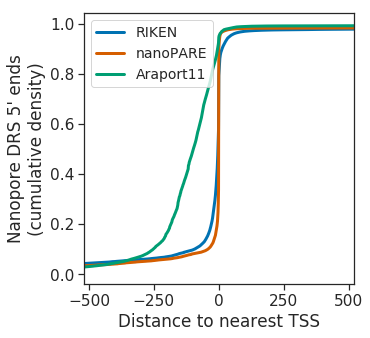

In [45]:
fig, ax = plt.subplots(figsize=(5.4, 5))

ax.plot(
    np.arange(-1000, 1000),
    full_length_hist[1:-1],
    label='RIKEN',
    linewidth=3
)

ax.plot(
    np.arange(-1000, 1000),
    nanoPARE_full_length_hist[1:-1],
    label='nanoPARE',
    linewidth=3
)

ax.plot(
    np.arange(-1000, 1000),
    araport11_full_length_hist[1:-1],
    label='Araport11',
    linewidth=3
)
ax.set_xlim(-520, 520)
plt.legend(fontsize=14, loc=2)
ax.set_xlabel('Distance to nearest TSS')
ax.set_ylabel('Nanopore DRS 5\' ends\n(cumulative density)')
plt.tight_layout()
plt.savefig('figures/riken_vs_araport_nanoPARE_vs_nanopore.svg')
plt.show()